In [22]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 
  
# metadata 
print(adult.metadata) 
  
# variable information 
print(adult.variables) 

{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

In [23]:
# ===== DATA TRANSFORMATIONS =====

# 1. Create binary variable for marital status (married or not)
# Assuming 'marital-status' column exists in the data
marital_status_mapping = {
    'Married-civ-spouse': 1,
    'Married-spouse-absent': 1,
    'Married-AF-spouse': 1
}
X['is_married'] = X['marital-status'].map(lambda x: marital_status_mapping.get(x, 0)).astype(int)

# 2. Convert education to ordinal variable with preserved order
# Extract education_order from the dataset using education-num column
education_mapping = X[['education', 'education-num']].drop_duplicates().sort_values('education-num')
education_order = education_mapping['education'].tolist()
education_mapping_dict = {edu: idx for idx, edu in enumerate(education_order)}

# Replace the education column with ordinal values
X['education'] = X['education'].map(education_mapping_dict).astype('int8')

# 3. Numerify sex column (1 = Male, 0 = Female)
X['sex'] = (X['sex'] == 'Male').astype('bool')

print("Transformations Applied:")
print("="*80)
print(f"✓ is_married: Binary variable created (1 = married, 0 = not married)")
print(f"✓ education: Converted to ordinal (0-{len(education_order)-1}) with preserved education progression")
print(f"✓ sex: Numerified (1 = Male, 0 = Female)")
print("\nDataFrame shape:", X.shape)
print("\nEducation order derived from dataset:")
for idx, edu in enumerate(education_order):
    print(f"  {idx}: {edu}")
print("\nNew columns created:")
print(f"  - is_married: {X['is_married'].value_counts().to_dict()}")
print(f"  - education (ordinal): range {X['education'].min()} to {X['education'].max()}")
print(f"  - sex (numerified): {X['sex'].value_counts().to_dict()}")



Transformations Applied:
✓ is_married: Binary variable created (1 = married, 0 = not married)
✓ education: Converted to ordinal (0-15) with preserved education progression
✓ sex: Numerified (1 = Male, 0 = Female)

DataFrame shape: (48842, 15)

Education order derived from dataset:
  0: Preschool
  1: 1st-4th
  2: 5th-6th
  3: 7th-8th
  4: 9th
  5: 10th
  6: 11th
  7: 12th
  8: HS-grad
  9: Some-college
  10: Assoc-voc
  11: Assoc-acdm
  12: Bachelors
  13: Masters
  14: Prof-school
  15: Doctorate

New columns created:
  - is_married: {0: 25798, 1: 23044}
  - education (ordinal): range 0 to 15
  - sex (numerified): {True: 32650, False: 16192}


In [24]:
# ===== MISSING VALUES ANALYSIS =====
import pandas as pd

print("Missing Values per Column:")
print("="*80)

missing_values = X.isnull().sum()
missing_percent = (missing_values / len(X)) * 100

missing_df = pd.DataFrame({
    'Column': X.columns,
    'Missing Count': missing_values.values,
    'Missing Percentage': missing_percent.values
}).sort_values('Missing Count', ascending=False)

print(missing_df.to_string(index=False))

print("\n" + "="*80)
print(f"Total rows: {len(X)}")
print(f"Total columns: {len(X.columns)}")
print(f"Columns with missing values: {(missing_values > 0).sum()}")
print(f"Columns without missing values: {(missing_values == 0).sum()}")


Missing Values per Column:
        Column  Missing Count  Missing Percentage
    occupation            966            1.977806
     workclass            963            1.971664
native-country            274            0.560993
        fnlwgt              0            0.000000
     education              0            0.000000
 education-num              0            0.000000
           age              0            0.000000
marital-status              0            0.000000
  relationship              0            0.000000
           sex              0            0.000000
          race              0            0.000000
  capital-gain              0            0.000000
  capital-loss              0            0.000000
hours-per-week              0            0.000000
    is_married              0            0.000000

Total rows: 48842
Total columns: 15
Columns with missing values: 3
Columns without missing values: 12


In [26]:
# ===== IMMIGRANT STATUS WITH FEATURE-BASED PROBABILISTIC IMPUTATION =====
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

print("Creating is_immigrant column with feature-based probabilistic imputation:")
print("="*80)

# Identify missing values in native-country
missing_country_mask = X['native-country'].isna()
print(f"Missing values in native-country: {missing_country_mask.sum()} ({100*missing_country_mask.sum()/len(X):.2f}%)")

# Create is_immigrant based on native-country for non-missing values
X['is_immigrant'] = (X['native-country'] != 'United-States').astype('bool')

# For missing values, use feature-based probabilistic imputation
if missing_country_mask.sum() > 0:
    print(f"\nTraining logistic regression model on {(~missing_country_mask).sum()} non-missing observations...")
    
    # Select relevant features for prediction
    feature_cols = ['age', 'education', 'hours-per-week', 'is_married', 'sex']
    
    # Prepare data for model training (non-missing country values)
    X_train = X[~missing_country_mask][feature_cols].copy()
    y_train = X[~missing_country_mask]['is_immigrant'].copy()
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Train logistic regression model
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train_scaled, y_train)
    
    # Calculate model accuracy on training data
    train_accuracy = model.score(X_train_scaled, y_train)
    print(f"Model training accuracy: {train_accuracy:.4f}")
    
    # Predict probabilities for missing values
    X_missing = X[missing_country_mask][feature_cols].copy()
    X_missing_scaled = scaler.transform(X_missing)
    prob_immigrant = model.predict_proba(X_missing_scaled)[:, 1]
    
    print(f"Probability statistics (missing observations):")
    print(f"  - Mean: {prob_immigrant.mean():.4f}")
    print(f"  - Min: {prob_immigrant.min():.4f}")
    print(f"  - Max: {prob_immigrant.max():.4f}")
    
    # Generate binary values based on predicted probabilities
    np.random.seed(42)  # For reproducibility
    imputed_values = (np.random.random(len(prob_immigrant)) < prob_immigrant).astype('bool')
    
    # Assign imputed values to missing rows
    X.loc[missing_country_mask, 'is_immigrant'] = imputed_values
    
    print(f"\nImputation complete!")
else:
    print("No missing values in native-country - no imputation needed.")

print("\nis_immigrant distribution:")
print(X['is_immigrant'].value_counts().sort_index())
print(f"\nData type: {X['is_immigrant'].dtype}")
print(f"Missing values after imputation: {X['is_immigrant'].isna().sum()}")
print(f"Memory usage: {X['is_immigrant'].memory_usage(deep=True)} bytes")
print("="*80)


Creating is_immigrant column with feature-based probabilistic imputation:
Missing values in native-country: 274 (0.56%)

Training logistic regression model on 48568 non-missing observations...
Model training accuracy: 0.9025
Probability statistics (missing observations):
  - Mean: 0.0897
  - Min: 0.0312
  - Max: 0.2825

Imputation complete!

is_immigrant distribution:
is_immigrant
False    44081
True      4761
Name: count, dtype: int64

Data type: bool
Missing values after imputation: 0
Memory usage: 48974 bytes


In [27]:
# ===== OUTLIER DETECTION AND REPORTING =====

print("Outlier Detection and Analysis Report")
print("="*80)

# Select numerical features for outlier detection
numerical_cols = ['age', 'hours-per-week']  # Primary outlier candidates

outlier_report = {}
rows_with_outliers = set()

# Detect outliers using IQR (Interquartile Range) method
print("\nOutlier Detection (IQR Method - 1.5 * IQR):")
print("-"*80)

for col in numerical_cols:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outlier_mask = (X[col] < lower_bound) | (X[col] > upper_bound)
    outlier_count = outlier_mask.sum()
    
    outlier_report[col] = {
        'count': outlier_count,
        'percentage': (outlier_count / len(X)) * 100,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'Q1': Q1,
        'Q3': Q3,
        'min_outlier': X[outlier_mask][col].min() if outlier_count > 0 else None,
        'max_outlier': X[outlier_mask][col].max() if outlier_count > 0 else None,
        'outlier_indices': X.index[outlier_mask].tolist()
    }
    
    # Track rows with outliers
    rows_with_outliers.update(outlier_report[col]['outlier_indices'])
    
    print(f"\n{col}:")
    print(f"  Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
    print(f"  Valid range: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"  Outliers found: {outlier_count} ({outlier_report[col]['percentage']:.2f}%)")
    if outlier_count > 0:
        print(f"  Outlier range: [{outlier_report[col]['min_outlier']:.2f}, {outlier_report[col]['max_outlier']:.2f}]")

# Prepare dataset for manual review
print("\n" + "="*80)
print(f"Total unique rows with outliers: {len(rows_with_outliers)}")
print(f"Percentage of data requiring review: {(len(rows_with_outliers)/len(X))*100:.2f}%")

# Create outlier review dataset
outlier_rows = X.loc[list(rows_with_outliers)].copy()
outlier_rows['outlier_in'] = ''

# Annotate which columns have outliers
for idx in outlier_rows.index:
    cols_with_outliers = []
    for col in numerical_cols:
        if idx in outlier_report[col]['outlier_indices']:
            cols_with_outliers.append(col)
    outlier_rows.loc[idx, 'outlier_in'] = ', '.join(cols_with_outliers)

# Reorder columns to show outlier annotation first
outlier_cols = ['outlier_in', 'age', 'sex', 'education', 'hours-per-week', 'is_married', 'is_immigrant']
available_cols = [col for col in outlier_cols if col in outlier_rows.columns]
outlier_review_df = outlier_rows[available_cols]

print("\nOutlier Review Dataset (first 20 rows):")
print("-"*80)
print(outlier_review_df.head(20).to_string())

if len(outlier_review_df) > 20:
    print(f"\n... and {len(outlier_review_df) - 20} more rows")

print("\n" + "="*80)
print("SUMMARY:")
print("-"*80)
print(f"Total records in dataset: {len(X)}")
print(f"Records with outliers: {len(outlier_rows)}")
print(f"Records without outliers: {len(X) - len(outlier_rows)}")
print("\nColumns with detected outliers:")
for col in numerical_cols:
    if outlier_report[col]['count'] > 0:
        print(f"  • {col}: {outlier_report[col]['count']} outliers")
print("\nAction Items:")
print("  - Review outlier_review_df for data quality issues")
print("  - Decide on handling: remove, transform, or keep as-is")
print("  - Update X with final decision")
print("="*80)


Outlier Detection and Analysis Report

Outlier Detection (IQR Method - 1.5 * IQR):
--------------------------------------------------------------------------------

age:
  Q1: 28.00, Q3: 48.00, IQR: 20.00
  Valid range: [-2.00, 78.00]
  Outliers found: 216 (0.44%)
  Outlier range: [79.00, 90.00]

hours-per-week:
  Q1: 40.00, Q3: 45.00, IQR: 5.00
  Valid range: [32.50, 52.50]
  Outliers found: 13496 (27.63%)
  Outlier range: [1.00, 99.00]

Total unique rows with outliers: 13576
Percentage of data requiring review: 27.80%

Outlier Review Dataset (first 20 rows):
--------------------------------------------------------------------------------
                outlier_in  age    sex  education  hours-per-week  is_married  is_immigrant
32768       hours-per-week   73   True          8              20           1         False
1           hours-per-week   50   True         12              13           1         False
32770       hours-per-week   31   True          9              55           

Feature Visualization
Numerical Features (2): ['age', 'hours-per-week']
Ordinal Features (1): ['education']
Binary Features (3): ['sex', 'is_married', 'is_immigrant']
Categorical Features (6): ['workclass', 'marital-status', 'occupation', 'relationship', 'race']...




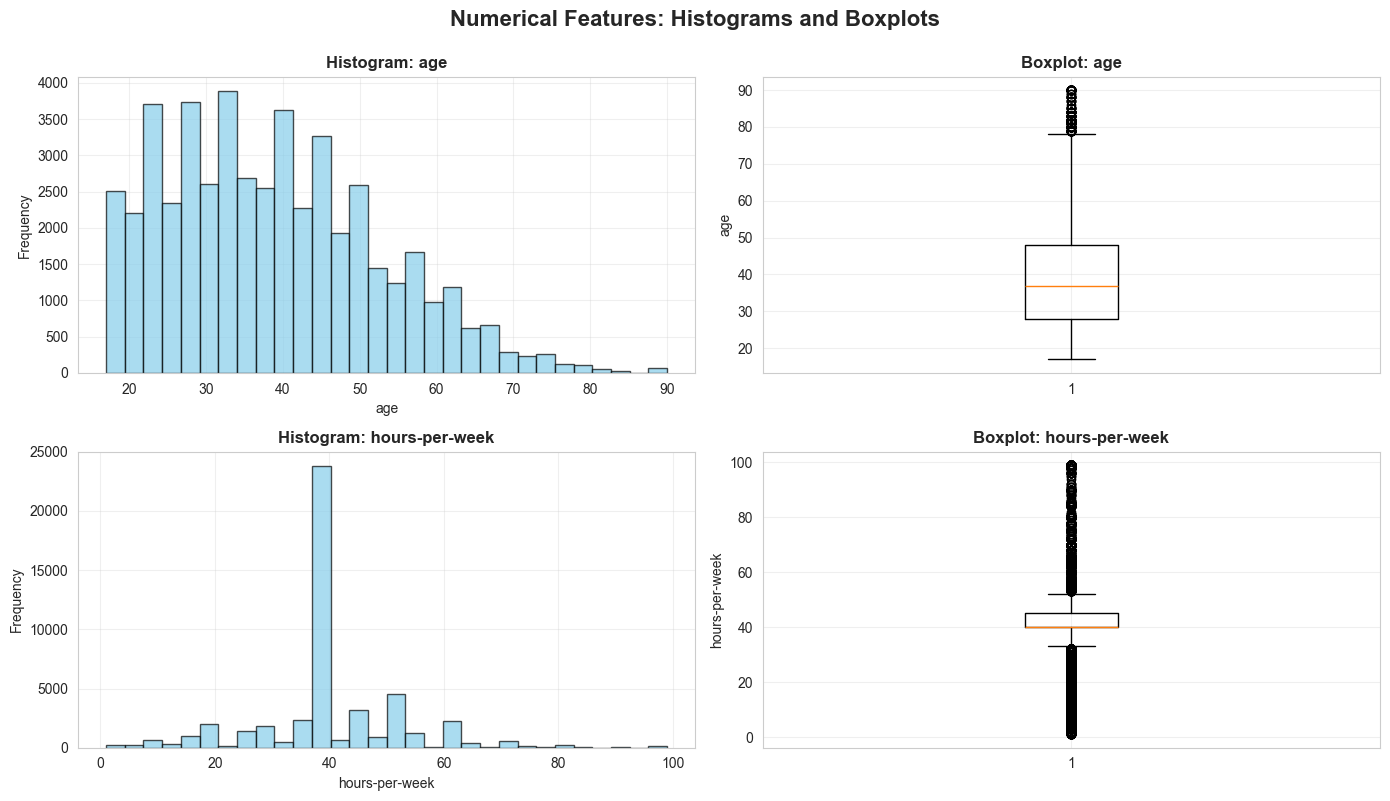

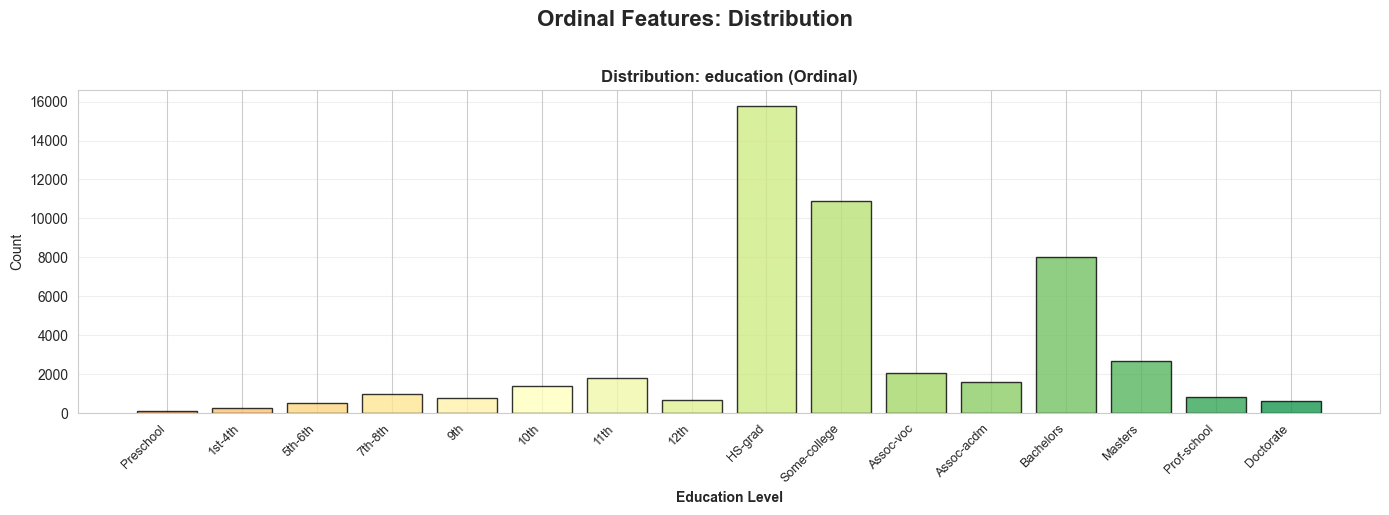

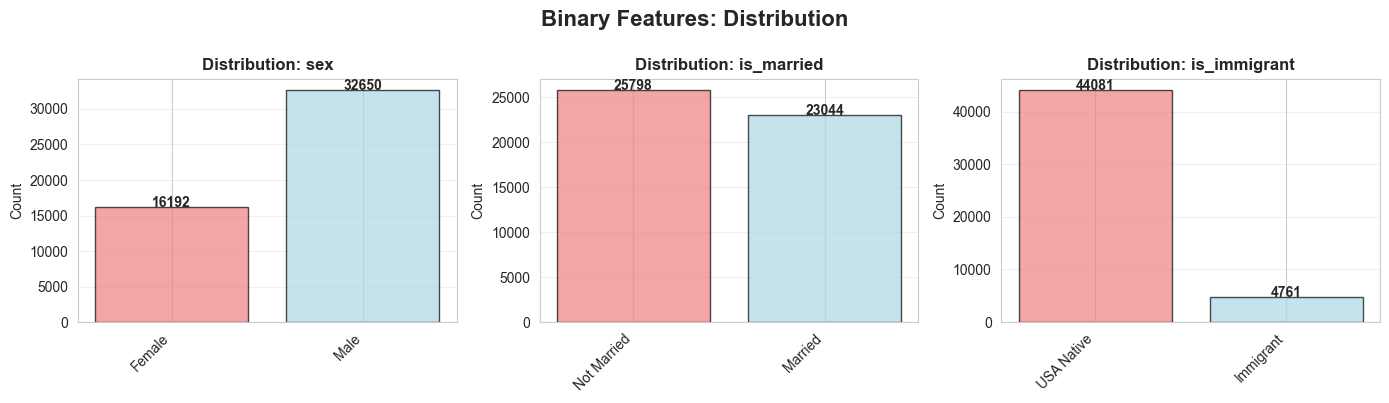

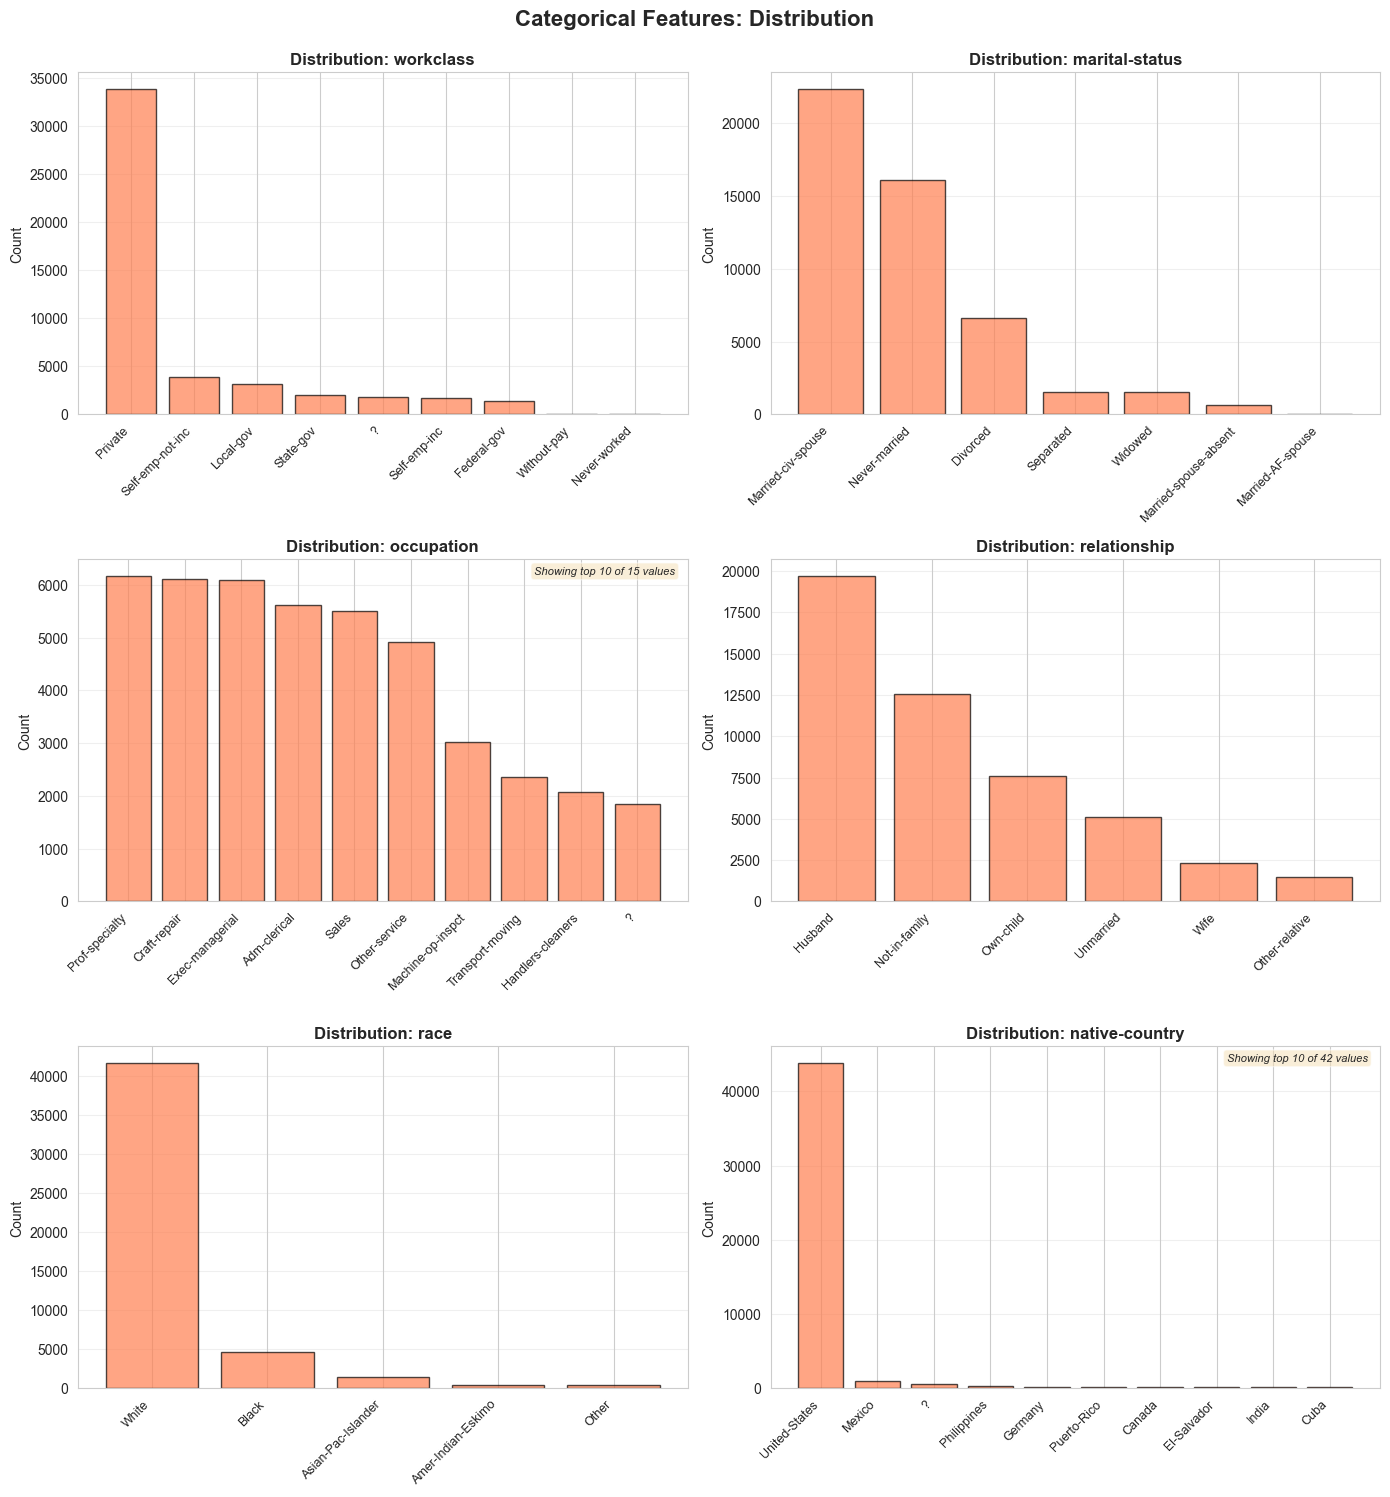


Visualization Summary:
✓ 2 numerical feature(s) visualized with histograms and boxplots
✓ 1 ordinal feature(s) visualized with ordered bar charts
✓ 3 binary feature(s) visualized with labeled bar charts
✓ 6 categorical feature(s) visualized with bar charts


In [28]:
# ===== FEATURE VISUALIZATION =====
import matplotlib.pyplot as plt
import seaborn as sns

print("Feature Visualization")
print("="*80)

# Configure visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# Categorize features
numerical_features = ['age', 'hours-per-week']
ordinal_features = ['education']
binary_features = ['sex', 'is_married', 'is_immigrant']
categorical_features = [col for col in X.select_dtypes(include=['object']).columns 
                       if col not in ordinal_features]

print(f"Numerical Features ({len(numerical_features)}): {numerical_features}")
print(f"Ordinal Features ({len(ordinal_features)}): {ordinal_features}")
print(f"Binary Features ({len(binary_features)}): {binary_features}")
print(f"Categorical Features ({len(categorical_features)}): {categorical_features[:5]}...")
print("\n" + "="*80 + "\n")

# ===== 1. NUMERICAL FEATURES: HISTOGRAMS AND BOXPLOTS =====
if len(numerical_features) > 0:
    fig, axes = plt.subplots(len(numerical_features), 2, figsize=(14, 4*len(numerical_features)))
    if len(numerical_features) == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle("Numerical Features: Histograms and Boxplots", fontsize=16, fontweight='bold', y=0.995)
    
    for idx, feature in enumerate(numerical_features):
        # Histogram
        axes[idx, 0].hist(X[feature].dropna(), bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        axes[idx, 0].set_title(f"Histogram: {feature}", fontweight='bold')
        axes[idx, 0].set_xlabel(feature)
        axes[idx, 0].set_ylabel("Frequency")
        axes[idx, 0].grid(alpha=0.3)
        
        # Boxplot
        axes[idx, 1].boxplot(X[feature].dropna(), vert=True)
        axes[idx, 1].set_title(f"Boxplot: {feature}", fontweight='bold')
        axes[idx, 1].set_ylabel(feature)
        axes[idx, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ===== 2. ORDINAL FEATURES: BAR CHARTS (with preserved order) =====
if len(ordinal_features) > 0:
    fig, axes = plt.subplots(1, len(ordinal_features), figsize=(14, 5))
    if len(ordinal_features) == 1:
        axes = [axes]
    
    fig.suptitle("Ordinal Features: Distribution", fontsize=16, fontweight='bold', y=1.02)
    
    for idx, feature in enumerate(ordinal_features):
        # Bar chart with preserved order (education)
        value_counts = X[feature].value_counts().sort_index()
        
        # Create bars with education level labels
        bar_labels = [education_order[i] for i in value_counts.index]
        colors_gradient = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(value_counts)))
        
        bars = axes[idx].bar(range(len(value_counts)), value_counts.values, 
                            color=colors_gradient, edgecolor='black', alpha=0.8)
        
        # Use education level names as x-axis labels
        axes[idx].set_xticks(range(len(value_counts)))
        axes[idx].set_xticklabels(bar_labels, rotation=45, ha='right', fontsize=9)
        axes[idx].set_xlabel("Education Level", fontweight='bold')
        
        axes[idx].set_title(f"Distribution: {feature} (Ordinal)", fontweight='bold')
        axes[idx].set_ylabel("Count")
        axes[idx].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

# ===== 3. BINARY FEATURES: BAR CHARTS =====
if len(binary_features) > 0:
    num_cols = min(3, len(binary_features))
    num_rows = (len(binary_features) + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 4*num_rows))
    
    if num_rows == 1 and num_cols == 1:
        axes = [axes]
    elif num_rows == 1 or num_cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    fig.suptitle("Binary Features: Distribution", fontsize=16, fontweight='bold', y=0.995)
    
    binary_labels = {
        'sex': {0: 'Female', 1: 'Male'},
        'is_married': {0: 'Not Married', 1: 'Married'},
        'is_immigrant': {0: 'USA Native', 1: 'Immigrant'}
    }
    
    for idx, feature in enumerate(binary_features):
        value_counts = X[feature].value_counts().sort_index()
        labels = [binary_labels.get(feature, {}).get(i, f'Value {i}') for i in value_counts.index]
        colors = ['lightcoral', 'lightblue']
        
        axes[idx].bar(range(len(value_counts)), value_counts.values, 
                     color=colors[:len(value_counts)], edgecolor='black', alpha=0.7)
        axes[idx].set_xticks(range(len(value_counts)))
        axes[idx].set_xticklabels(labels, rotation=45, ha='right')
        axes[idx].set_title(f"Distribution: {feature}", fontweight='bold')
        axes[idx].set_ylabel("Count")
        axes[idx].grid(alpha=0.3, axis='y')
        
        # Add value labels on bars
        for i, v in enumerate(value_counts.values):
            axes[idx].text(i, v + 10, str(v), ha='center', fontweight='bold')
    
    # Hide empty subplots
    for idx in range(len(binary_features), num_rows * num_cols):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# ===== 4. CATEGORICAL FEATURES: BAR CHARTS =====
if len(categorical_features) > 0:
    num_cols = 2
    num_rows = (len(categorical_features) + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 5*num_rows))
    
    if num_rows == 1 and num_cols == 1:
        axes = np.array([[axes]])
    elif num_rows == 1 or num_cols == 1:
        axes = axes.reshape(num_rows, num_cols)
    
    fig.suptitle("Categorical Features: Distribution", fontsize=16, fontweight='bold', y=0.995)
    
    for idx, feature in enumerate(categorical_features):
        row = idx // num_cols
        col = idx % num_cols
        
        # Count plot
        value_counts = X[feature].value_counts().head(10)  # Top 10 values
        axes[row, col].bar(range(len(value_counts)), value_counts.values, 
                          color='coral', edgecolor='black', alpha=0.7)
        axes[row, col].set_xticks(range(len(value_counts)))
        axes[row, col].set_xticklabels(value_counts.index, rotation=45, ha='right', fontsize=9)
        axes[row, col].set_title(f"Distribution: {feature}", fontweight='bold')
        axes[row, col].set_ylabel("Count")
        axes[row, col].grid(alpha=0.3, axis='y')
        
        # Add count annotation
        if len(value_counts) < X[feature].nunique():
            axes[row, col].text(0.98, 0.98, f"Showing top 10 of {X[feature].nunique()} values", 
                               transform=axes[row, col].transAxes, ha='right', va='top', 
                               fontsize=8, style='italic', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Hide empty subplots
    for idx in range(len(categorical_features), num_rows * num_cols):
        row = idx // num_cols
        col = idx % num_cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()

print("\nVisualization Summary:")
print("="*80)
print(f"✓ {len(numerical_features)} numerical feature(s) visualized with histograms and boxplots")
print(f"✓ {len(ordinal_features)} ordinal feature(s) visualized with ordered bar charts")
print(f"✓ {len(binary_features)} binary feature(s) visualized with labeled bar charts")
print(f"✓ {len(categorical_features)} categorical feature(s) visualized with bar charts")
print("="*80)
